In [ ]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.layers import Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Embedding, Add, MaxPool1D,ZeroPadding1D, LSTM
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers
from keras.models import Sequential, Model

from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

import seaborn as sns
from sklearn.metrics import confusion_matrix


%matplotlib inline



In [ ]:
!git clone https://github.com/nafisa003/mit-bih-dataset.git

Cloning into 'mit-bih-dataset'...
remote: Enumerating objects: 98, done.
remote: Total 98 (delta 0), reused 0 (delta 0), pack-reused 98
Unpacking objects: 100% (98/98), done.
Checking out files: 100% (96/96), done.


In [ ]:
'''
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

'''

'\nplt.rcParams["figure.figsize"] = (30,6)\nplt.rcParams[\'lines.linewidth\'] = 1\nplt.rcParams[\'lines.color\'] = \'b\'\nplt.rcParams[\'axes.grid\'] = True \n\n'

In [ ]:
def denoise(data): 
    w = pywt.Wavelet('db10')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.03 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'db10', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'db10')
    
    return datarec

In [ ]:
path = '/content/mit-bih-dataset/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'S', 'F', 'V', 'Q']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [ ]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()
print(filenames)

['100.csv', '100annotations.txt', '101.csv', '101annotations.txt', '102.csv', '102annotations.txt', '103.csv', '103annotations.txt', '104.csv', '104annotations.txt', '105.csv', '105annotations.txt', '106.csv', '106annotations.txt', '107.csv', '107annotations.txt', '108.csv', '108annotations.txt', '109.csv', '109annotations.txt', '111.csv', '111annotations.txt', '112.csv', '112annotations.txt', '113.csv', '113annotations.txt', '114.csv', '114annotations.txt', '115.csv', '115annotations.txt', '116.csv', '116annotations.txt', '117.csv', '117annotations.txt', '118.csv', '118annotations.txt', '119.csv', '119annotations.txt', '121.csv', '121annotations.txt', '122.csv', '122annotations.txt', '123.csv', '123annotations.txt', '124.csv', '124annotations.txt', '200.csv', '200annotations.txt', '201.csv', '201annotations.txt', '202.csv', '202annotations.txt', '203.csv', '203annotations.txt', '205.csv', '205annotations.txt', '207.csv', '207annotations.txt', '208.csv', '208annotations.txt', '209.csv'

In [ ]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

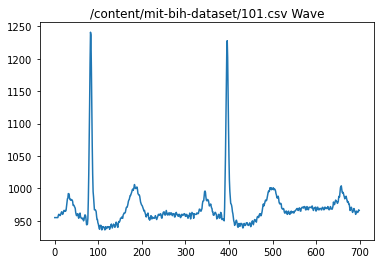

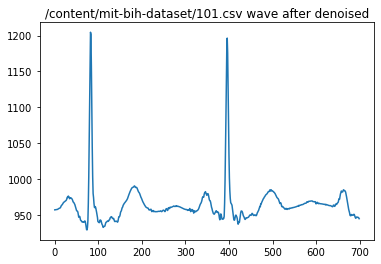

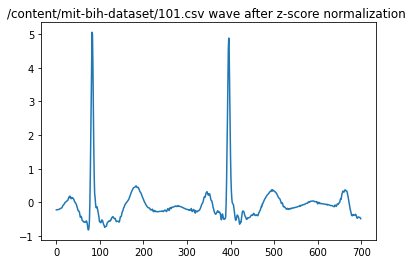

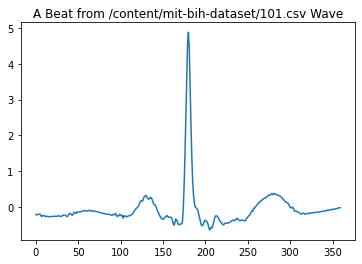

(82977, 360) (82977,)


In [ ]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [ ]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(82977, 361)


0.0    75011
3.0     7129
2.0      802
4.0       33
1.0        2
Name: 360, dtype: int64


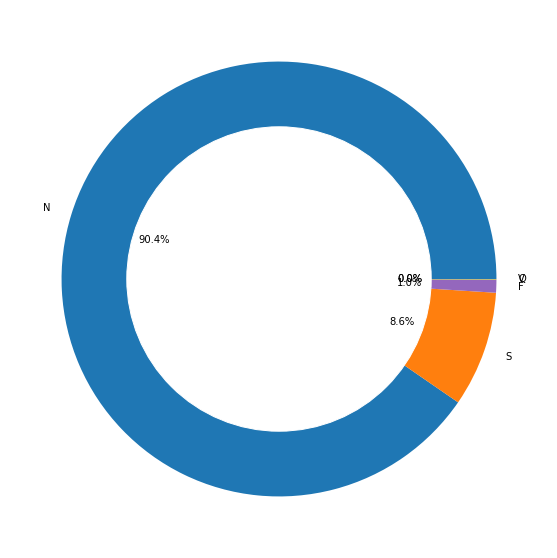

In [ ]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'S', 'F', 'V', 'Q'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 360, dtype: int64


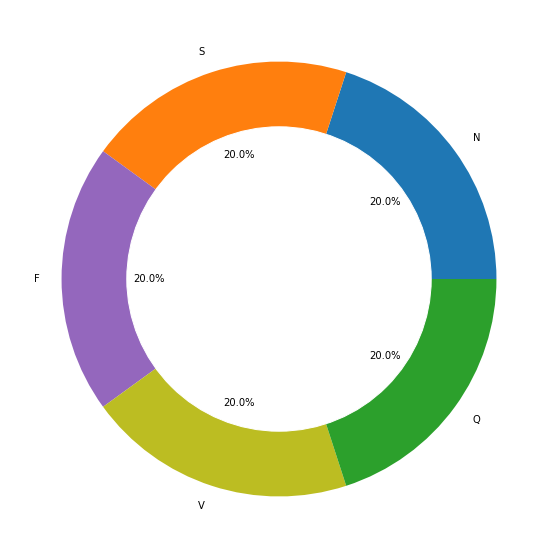

In [ ]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'S', 'F', 'V', 'Q'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [ ]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [ ]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    conv1 = inputs
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=14, padding="same",activation="relu")(conv1)
    # conv1 = keras.layers.BatchNormalization()(conv1)
    conv2 = keras.layers.Conv1D(filters=32, kernel_size=10, padding="same",activation="relu")(conv1)
    # conv2 = keras.layers.BatchNormalization()(conv2)
    conv3 = keras.layers.Conv1D(filters=16, kernel_size=10, padding="same",activation="relu")(conv2)
    # conv3 = keras.layers.BatchNormalization()(conv3)
    x=conv3
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    
    cnn_trans=x
    input_layer=inputs
    y=input_layer
    y=(layers.Bidirectional(LSTM(128,return_sequences=True)))(y)
    y=(layers.Bidirectional(LSTM(128, return_sequences=True)))(y)

    # y=layers.MaxPooling1D(2)(y)
    y=(layers.Dense(352, activation='relu'))(y)
    y=(layers.Dense(100, activation='relu'))(y)
    y=(layers.Dense(32, activation='relu'))(y)


    y=layers.GlobalAveragePooling1D()(y)
    blstm_out=y
    merge=layers.concatenate([cnn_trans,blstm_out])
    outputs = layers.Dense(5, activation="softmax")(merge)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = (train_x.shape[1:])
print(input_shape)

model = build_model(
    input_shape,
    head_size=256,
    num_heads=8,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[1012],
    mlp_dropout=0,
    dropout=0.15,
)
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)
model.compile(
    loss="categorical_crossentropy",
    # optimizer=keras.optimizers.Adam(learning_rate=1e-6),
    optimizer="adam",
    metrics=["accuracy"]
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True),
keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_accuracy"
),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.000001
    )
    ]


# model.evaluate(test_x, test_y, verbose=1)

(360, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 360, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 360, 64)      960         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 360, 32)      20512       ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 360, 16)      5136        ['conv1d_1[0][0]']               
                                                                                     

In [ ]:


history=model.fit(
    train_x,
    train_y,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
   
)


Epoch 1/15
250/250 [==============================] - 203s 745ms/step - loss: 0.3978 - accuracy: 0.8576 - val_loss: 0.1354 - val_accuracy: 0.9545 - lr: 0.0010
Epoch 2/15
250/250 [==============================] - 193s 772ms/step - loss: 0.1363 - accuracy: 0.9537 - val_loss: 0.1218 - val_accuracy: 0.9523 - lr: 0.0010
Epoch 3/15
250/250 [==============================] - 194s 775ms/step - loss: 0.0944 - accuracy: 0.9681 - val_loss: 0.0814 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 4/15
250/250 [==============================] - 193s 773ms/step - loss: 0.0812 - accuracy: 0.9728 - val_loss: 0.0850 - val_accuracy: 0.9707 - lr: 0.0010
Epoch 5/15
250/250 [==============================] - 194s 775ms/step - loss: 0.0548 - accuracy: 0.9807 - val_loss: 0.0758 - val_accuracy: 0.9770 - lr: 0.0010
Epoch 6/15
250/250 [==============================] - 193s 772ms/step - loss: 0.0482 - accuracy: 0.9838 - val_loss: 0.1133 - val_accuracy: 0.9672 - lr: 0.0010
Epoch 7/15
250/250 [==========================

In [ ]:
model = keras.models.load_model("best_model.h5")

In [ ]:
test_loss, test_acc = model.evaluate(test_x, test_y)

157/157 [==============================] - 23s 131ms/step - loss: 0.0426 - accuracy: 0.9922


157/157 [==============================] - 21s 135ms/step
CNN-Transformer+BILSTM
Precision: 0.992
F1 Score: 0.992
Recall: 0.992
Accuracy: 0.992


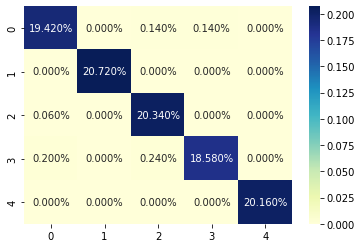

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=model.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)

custCnnConfMat = confusion_matrix(y_true, prediction)
sns.heatmap(custCnnConfMat/np.sum(custCnnConfMat), annot=True,fmt='.3%', cmap='YlGnBu')
plt.savefig('custCnnconfMat.png')


print("CNN-Transformer+BILSTM")
print('Precision: %.3f' % precision_score(y_true, prediction, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true, prediction, average='micro'))
print('Recall: %.3f' % recall_score(y_true, prediction, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true, prediction))